# Ingesting UKDRI CRT Data with the DCARTE

## Developing a recipe of your own 

Until now, we covered how to configure and use dcarte to download the raw datasets collected by the ukdri. We've also learned that dcarte has three derived domains to extend its capabilities by adding some cleaning logic over the raw data.

In the last tutorial, we will create a new domain and one new derived dataset.

We start like always by loading some key libraries. 

In [1]:
import dcarte 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

This notebook deconstructs the motion dataset in the base domain. We will go over the different steps taken to create this dataset as an example that I hope you can take further in your research.

In [2]:
dcarte.__version__

'0.3.25'

Here I am reloading the entire motion dataset to review the different parts that create this simple building block dataset.   
**please don't run this during the tutorial as it will take around 50 min to reconstruct this dataset completely**

In [4]:
motion = dcarte.load('motion', 'base',reload=True)


Processing activity :*******************************************************************************************

After the initial download, we have an updated version of the different parent datasets needed to reconstruct the motion dataset. And loading the dataset is very fast.

In [3]:
motion = dcarte.load('motion', 'base')

Finished Loading motion in:                    0.7 seconds   


As you can see, the motion dataset uses various datasets, all updated to a recent version since we just reloaded them.  
let's load the different elements using dcarte.

In [211]:
activity = dcarte.load('activity', 'raw')
entryway = dcarte.load('entryway', 'base')
bed_occupancy = dcarte.load('bed_occupancy', 'base')

Finished Loading activity in:                  1.8 seconds   
Finished Loading entryway in:                  0.0 seconds   
Finished Loading sleep in:                     2.6 seconds   


In [213]:
bed_occupancy = bed_occupancy[['start_date','patient_id','location_name']]

In [219]:
activity = activity[['start_date','patient_id','location_name']]

In [222]:
entryway = entryway[['start_date','patient_id','location_name']]

In [223]:
bed_occupancy = (bed_occupancy.
 set_index('start_date').
 groupby('patient_id').
 apply(mine_bed_occupancy)).reset_index()

In [227]:
bed_occupancy = bed_occupancy[['start_date','patient_id','activity']]
bed_occupancy.columns = entryway.columns

In [229]:
motion = pd.concat([activity,bed_occupancy,entryway])

In [232]:
motion = motion.sort_values(['patient_id','start_date'])

In [303]:
transition = motion.groupby('patient_id').apply(mine_transtion,value='location_name',window=2)

In [394]:
vital_signs = dcarte.load('Vital_Signs','raw',since='2021-04-01',until='2021-08-01',reload=True)

Processing vital_signs :*

Finished Loading Vital_Signs in:              40.8 seconds   


In [ ]:
vital_signs

In [292]:
start_event = transition.query('source == "bed_out" and sink == "bedroom1"')
end_event = transition.query('source == "bedroom1" and sink == "bed_in"')

In [308]:
dd

,start_date,patient_id,location_name
245370,2021-05-14 12:34:46,2GN1PHeHwRzNYQ7q4Nvg7g,bathroom1
245371,2021-05-14 12:34:51,2GN1PHeHwRzNYQ7q4Nvg7g,kitchen
245372,2021-05-14 12:34:52,2GN1PHeHwRzNYQ7q4Nvg7g,bedroom1
245375,2021-05-14 12:34:55,2GN1PHeHwRzNYQ7q4Nvg7g,hallway
245376,2021-05-14 12:34:55,2GN1PHeHwRzNYQ7q4Nvg7g,lounge
...,...,...,...
5552811,2022-02-19 17:04:39,2GN1PHeHwRzNYQ7q4Nvg7g,hallway
5552815,2022-02-19 17:05:02,2GN1PHeHwRzNYQ7q4Nvg7g,lounge
5553078,2022-02-19 17:14:05,2GN1PHeHwRzNYQ7q4Nvg7g,lounge
5553100,2022-02-19 17:14:52,2GN1PHeHwRzNYQ7q4Nvg7g,lounge


In [310]:
dd = motion.query('patient_id == "2GN1PHeHwRzNYQ7q4Nvg7g"')
ix_out = np.where(dd.location_name=="bed_out")[0]
ix_in = np.where(dd.location_name=="bed_in")[0]

In [313]:
d1 = dd.query('location_name in ["bed_out","bed_in"]')

In [363]:
def mine_pathway(df:pd.DataFrame,
                 value:str = 'location_name',
                 source:str='bed_out',
                 sink:str='bed_in',
                 min_dur:float=180,
                 max_dur:float=900):
    transitions = mine_transition(df.query(f'{value} in ["{source}","{sink}"]'),
                                  value=value)
    if not transitions.empty:
        events = (transitions.
                query(f'transition == "{source}>{sink}"').
                query(f'dur>{min_dur} and dur<{max_dur}'))
        pattern = []
        for s,e in zip(events.start_date,events.end_date):
            tmp = ">".join(df.set_index('start_date').loc[s:e].location_name.values)
            pattern.append(tmp)
        events['pathway'] = pattern
        return events   
    else:
        return pd.DataFrame()

In [376]:
motion.query('patient_id == "KGb3SK67baYUJdMVBVoLzP"').query('location_name in ["bed_out","bed_in"]')

,start_date,patient_id,location_name
51574,2021-07-10 00:46:00,KGb3SK67baYUJdMVBVoLzP,bed_out
51575,2021-07-10 00:48:00,KGb3SK67baYUJdMVBVoLzP,bed_in
51576,2021-07-10 01:10:00,KGb3SK67baYUJdMVBVoLzP,bed_out
51577,2021-07-10 01:11:00,KGb3SK67baYUJdMVBVoLzP,bed_in
51578,2021-07-10 01:13:00,KGb3SK67baYUJdMVBVoLzP,bed_out
...,...,...,...
51781,2021-07-11 09:55:00,KGb3SK67baYUJdMVBVoLzP,bed_in
51782,2021-07-11 09:56:00,KGb3SK67baYUJdMVBVoLzP,bed_out
51783,2021-07-11 09:58:00,KGb3SK67baYUJdMVBVoLzP,bed_in
51784,2021-07-11 09:59:00,KGb3SK67baYUJdMVBVoLzP,bed_out


In [387]:
dd = mine_pathway(motion.query('patient_id == "TwiUT1L1KSVnRdBuEywxfh"'),
                  source='bed_out',sink='bathroom1', min_dur=120,max_dur=1200)
dd.groupby('pathway').agg(mean_dur = ('dur','mean'),
                          std_dur = ('dur','std'),
                          obs_count = ('dur','count'))

,mean_dur,std_dur,obs_count
pathway,,,
bed_out>bed_in>bedroom1>bathroom1,160.000,NaN,1
bed_out>bedroom1>bathroom1,658.500,375.473701,2
bed_out>bedroom1>bedroom1>bathroom1,404.875,270.126657,8
bed_out>bedroom1>bedroom1>bedroom1>bathroom1,569.500,4.949747,2
bed_out>bedroom1>bedroom1>bedroom1>bedroom1>bathroom1,940.500,190.211724,2
bed_out>bedroom1>bedroom1>bedroom1>bedroom1>bedroom1>bedroom1>hallway>lounge>hallway>bedroom1>bathroom1,1060.000,NaN,1
bed_out>bedroom1>bedroom1>bedroom1>bedroom1>lounge>hallway>bed_in>bedroom1>bathroom1,1008.000,NaN,1
bed_out>bedroom1>bedroom1>bedroom1>hallway>bathroom1,396.000,NaN,1
bed_out>bedroom1>bedroom1>bedroom1>hallway>kitchen>hallway>bedroom1>bathroom1,605.000,NaN,1


bed_out>bed_in                                                                                           127
bed_out>bedroom1>bed_in                                                                                    6
bed_out>bedroom1>bedroom1>bedroom1>bedroom1>bed_in                                                         5
bed_out>bedroom1>bedroom1>bedroom1>bed_in                                                                  4
bed_out>bedroom1>bedroom1>bed_in                                                                           2
bed_out>bathroom1>bathroom1>bathroom1>bathroom1>bathroom1>bedroom1>bed_in                                  1
hallway>bed_out>hallway>hallway>lounge>lounge>bed_in                                                       1
bed_out>lounge>hallway>bedroom1>bed_in                                                                     1
bed_out>lounge>bed_in                                                                                      1
bed_out>kitchen>kit

In [325]:
pattern = []
for s,e in zip(events.start_date,events.end_date):
    tmp = ">".join(dd.set_index('start_date').loc[s:e].location_name.values)
    pattern.append(tmp)

In [326]:
pattern

['bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bedroom1>bedroom1>bathroom1>bed_in',
 'bed_out>bathroom1>bedroom1>bedroom1>bedroom1>bedroom1>bedroom1>bedroom1>bed_in',
 'bed_out>bed_in',
 'bed_out>bedroom1>bed_in',
 'bed_out>bathroom1>bedroom1>bedroom1>bedroom1>bedroom1>bedroom1>bed_in',
 'bed_out>bedroom1>bedroom1>bed_in',
 'bed_out>bedroom1>bedroom1>hallway>bed_in',
 'bed_out>bathroom1>lounge>bathroom1>lounge>hallway>bathroom1>bed_in',
 'bed_out>bathroom1>bathroom1>bed_in',
 'bed_out>bed_in',
 'bed_out>bedroom1>bedroom1>bedroom1>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>bed_in',
 'bed_out>kitchen>kitchen>kitchen>kitchen>kitchen>lounge>bedroom1>bedroom1>bedroom1>bed_in',
 'bed_out>bed_in',
 'bed_out>front door>front door>bed_in',
 'bed_out>bed_in',
 'bed_out>bathroom1>hallway>bedroom1>bedroom1>bathroom1>bathroom1>bathroom1>bathroom1>bed_in

patient_id
2GN1PHeHwRzNYQ7q4Nvg7g    AxesSubplot(0.125,0.125;0.775x0.755)
2zbyXzYNKPwiPtjaA2L64o    AxesSubplot(0.125,0.125;0.775x0.755)
3hY7Mp7u9YPo1xMARSxLhc    AxesSubplot(0.125,0.125;0.775x0.755)
4h1dAuzg9rdrhyojwxUS26    AxesSubplot(0.125,0.125;0.775x0.755)
5aQpCSrtPFyympF2G14a6c    AxesSubplot(0.125,0.125;0.775x0.755)
                                          ...                 
WtYLx1dEr6hHgQDg8TKcGP    AxesSubplot(0.125,0.125;0.775x0.755)
XsfBVz6GP7XtvhY4CiAvuf    AxesSubplot(0.125,0.125;0.775x0.755)
Xv41AaXiVYBKFAa7SLq8F5    AxesSubplot(0.125,0.125;0.775x0.755)
YJMET4inKfFcBERma2tQRi    AxesSubplot(0.125,0.125;0.775x0.755)
YYGGmsEaf2gP4JNN9kMprV    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dur, Length: 61, dtype: object

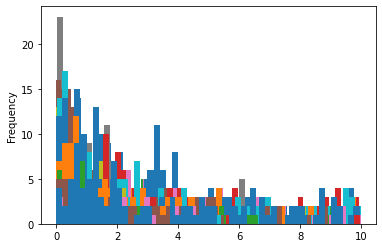

In [300]:
(end_event[end_event.dur<600].dur/60).groupby('patient_id').plot.hist(bins=50)

In [271]:
df = subset.reset_index()
datetime = 'start_date'
window = 1
value = 'location_name'
dur = (df[datetime].shift(-window) - 
        df[datetime]).dt.total_seconds().rename('dur')
start_date = df[datetime].rename('start_date')
end_date = df[datetime].shift(-window).rename('end_date')
source = df[value].rename('source')
sink = df[value].shift(-window).rename('sink')
transition = pd.Series(rolling_window(df[value].values,window+1)).rename('transition')


In [272]:
transition.reindex(sink.index)

0        bathroom1>kitchen
1         kitchen>bedroom1
2         bedroom1>hallway
3           hallway>lounge
4            lounge>lounge
               ...        
69326       hallway>lounge
69327        lounge>lounge
69328        lounge>lounge
69329        lounge>lounge
69330                  NaN
Name: transition, Length: 69331, dtype: object

In [273]:
pd.concat([start_date, end_date, source,sink,transition, dur], axis=1)

,start_date,end_date,source,sink,transition,dur
0,2021-05-14 12:34:46,2021-05-14 12:34:51,bathroom1,kitchen,bathroom1>kitchen,5.0
1,2021-05-14 12:34:51,2021-05-14 12:34:52,kitchen,bedroom1,kitchen>bedroom1,1.0
2,2021-05-14 12:34:52,2021-05-14 12:34:55,bedroom1,hallway,bedroom1>hallway,3.0
3,2021-05-14 12:34:55,2021-05-14 12:34:55,hallway,lounge,hallway>lounge,0.0
4,2021-05-14 12:34:55,2021-05-14 12:35:37,lounge,lounge,lounge>lounge,42.0
...,...,...,...,...,...,...
69326,2022-02-19 17:04:39,2022-02-19 17:05:02,hallway,lounge,hallway>lounge,23.0
69327,2022-02-19 17:05:02,2022-02-19 17:14:05,lounge,lounge,lounge>lounge,543.0
69328,2022-02-19 17:14:05,2022-02-19 17:14:52,lounge,lounge,lounge>lounge,47.0
69329,2022-02-19 17:14:52,2022-02-19 17:17:58,lounge,lounge,lounge>lounge,186.0


In [274]:
mine_transtion(subset,value='location_name',datetime='start_date',window=3)

,start_date,end_date,source,sink,transition,dur
0,2021-05-14 12:34:46,2021-05-14 12:34:55,bathroom1,hallway,bathroom1>kitchen>bedroom1>hallway,9.0
1,2021-05-14 12:34:51,2021-05-14 12:34:55,kitchen,lounge,kitchen>bedroom1>hallway>lounge,4.0
2,2021-05-14 12:34:52,2021-05-14 12:35:37,bedroom1,lounge,bedroom1>hallway>lounge>lounge,45.0
3,2021-05-14 12:34:55,2021-05-14 12:36:49,hallway,lounge,hallway>lounge>lounge>lounge,114.0
4,2021-05-14 12:34:55,2021-05-14 12:36:49,lounge,bedroom1,lounge>lounge>lounge>bedroom1,114.0
...,...,...,...,...,...,...
69326,2022-02-19 17:04:39,2022-02-19 17:14:52,hallway,lounge,hallway>lounge>lounge>lounge,613.0
69327,2022-02-19 17:05:02,2022-02-19 17:17:58,lounge,lounge,lounge>lounge>lounge>lounge,776.0
69328,2022-02-19 17:14:05,NaT,lounge,NaN,NaN,NaN
69329,2022-02-19 17:14:52,NaT,lounge,NaN,NaN,NaN


In [275]:
transition

0        bathroom1>kitchen
1         kitchen>bedroom1
2         bedroom1>hallway
3           hallway>lounge
4            lounge>lounge
               ...        
69325     bedroom1>hallway
69326       hallway>lounge
69327        lounge>lounge
69328        lounge>lounge
69329        lounge>lounge
Name: transition, Length: 69330, dtype: object

In [277]:
def mine_bed_occupancy(df):
    return (df.
            sort_index().
            drop_duplicates().
            assign(activity=1).
            asfreq('1T').
            activity.
            fillna(0).
            diff().
            to_frame().
            query('activity in [-1,1]').
            activity.
            map({-1:'bed_out',1:'bed_in'}).
            to_frame())

In [278]:
motion.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5864036 entries, 245370 to 5561392
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   start_date     datetime64[ns]
 1   patient_id     object        
 2   location_name  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 179.0+ MB


In [279]:
import typing

def process_transition(df:pd.DataFrame, 
                       datetime:str, 
                       value:str,
                       groupby:typing.Optional[list]=None, 
                       covariates:typing.Optional[list]=None) -> pd.DataFrame:
    """process_transition convert a timeseries DataFrame with datetimes to a transition dataframe 

    Args:
        df (pd.DataFrame): [description]
        datetime (str): [description]
        value (str): [description]
        groupby ([type], optional): [description]. Defaults to None.
        covariates ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    data = []
    df = df.sort_values(datetime)
    for ix, subset in df.groupby(groupby):
        if groupby is None:
            index = np.tile(ix, subset.shape[0])
        else:
            index = pd.MultiIndex.from_tuples(
                [ix for _ in range(subset.shape[0])], names=groupby)
        subset = subset.reset_index(drop=True)
        dur = (subset[datetime].shift(-1) - 
               subset[datetime]).dt.total_seconds().rename('dur')
        start_date = subset[datetime].rename('start_date')
        end_date = subset[datetime].shift(-1).rename('end_date')
        source = subset[value].astype(str).rename('source')
        sink = subset[value].shift(-1).astype(str).rename('sink')
        transition = (source + '>' + sink).rename('transition')
        if covariates is None:
            subset = pd.concat([start_date, end_date, source,sink,transition, dur], axis=1)
        else:
            cov = subset[covariates]
            subset = pd.concat([start_date, end_date , source , sink, cov, transition, dur], axis=1)
            
        subset.index = index
        subset.index.names = groupby
        data.append(subset.dropna())
    data = pd.concat(data)
    dtypes = {'start_date': 'datetime64',
              'end_date': 'datetime64',
              'source':'category',
              'sink':'category',
              'transition': 'category',
              'dur': 'float'}
    return data.astype(dtypes)

In [355]:
def mine_transition(df,value:str,datetime:str='start_date',window:int=1):
    df = df.sort_values(datetime).drop_duplicates().reset_index()
    if not df.empty:
       dur = (df[datetime].shift(-window) - 
              df[datetime]).dt.total_seconds().rename('dur')
       start_date = df[datetime].rename('start_date')
       end_date = df[datetime].shift(-window).rename('end_date')
       source = df[value].rename('source')
       sink = df[value].shift(-window).rename('sink')
       transition = pd.Series(rolling_window(df[value].values,window+1)).rename('transition')
       return pd.concat([start_date, end_date, source,sink,transition.reindex(sink.index), dur], axis=1)
    else:
       return pd.DataFrame()    

In [281]:
.set_index('start_date').

SyntaxError: invalid syntax (1371279655.py, line 1)

In [ ]:
dd = mine_transtion((sleep.set_index('start_date').
                           query('patient_id=="Mhy2uUxJnCtsEZbToCDDEE"').
                           drop_duplicates().
                           assign(activity=1).
                           asfreq('1T').
                           activity.
                           fillna(0).
                           diff().
                           to_frame().
                           query('activity in [-1,1]').
                           activity.
                           map({-1:'bed_out',1:'bed_in'}).
                           to_frame().
                           reset_index())
                    ,'activity','start_date',1)

In [ ]:
dd.query('dur>6000')


,start_date,end_date,source,sink,transition,dur
134,2019-04-01 08:40:00,2019-04-01 22:05:00,bed_out,bed_in,bed_out>bed_in,48300.0
212,2019-04-02 07:03:00,2019-04-02 22:58:00,bed_out,bed_in,bed_out>bed_in,57300.0
268,2019-04-03 07:10:00,2019-04-03 22:43:00,bed_out,bed_in,bed_out>bed_in,55980.0
310,2019-04-04 03:38:00,2019-04-04 05:56:00,bed_out,bed_in,bed_out>bed_in,8280.0
322,2019-04-04 07:18:00,2019-04-04 18:44:00,bed_out,bed_in,bed_out>bed_in,41160.0
...,...,...,...,...,...,...
1738,2022-01-26 00:26:00,2022-02-02 23:57:00,bed_out,bed_in,bed_out>bed_in,689460.0
1740,2022-02-02 23:58:00,2022-02-04 03:23:00,bed_out,bed_in,bed_out>bed_in,98700.0
1744,2022-02-04 04:04:00,2022-02-05 04:36:00,bed_out,bed_in,bed_out>bed_in,88320.0
1746,2022-02-05 04:37:00,2022-02-07 23:50:00,bed_out,bed_in,bed_out>bed_in,241980.0


In [ ]:
from dcarte.utils import  between_time
(between_time(transtions,'start_date','18:00','10:00').
 query('(transition in ["Bathroom>Bedroom","Bedroom>Bathroom"])').
 groupby('patient_id').
 resample('1D',offset='12h',on='start_date').
 agg(dur_mean = ('dur','mean'),
     obs_count = ('dur','count'),
     dur_std = ('dur','std')))


dur_mean  obs_count     dur_std
patient_id             start_date                                            
2GN1PHeHwRzNYQ7q4Nvg7g 2021-05-14 12:00:00   81.200000          5   22.587607
                       2021-05-15 12:00:00   92.000000          4  130.560331
                       2021-05-16 12:00:00   91.250000          4   56.387794
                       2021-05-17 12:00:00  207.000000          5  121.158986
                       2021-05-18 12:00:00  113.666667          3   40.414519
...                                                ...        ...         ...
YYGGmsEaf2gP4JNN9kMprV 2022-02-14 12:00:00  422.000000          4  748.677946
                       2022-02-15 12:00:00  129.000000          1         NaN
                       2022-02-16 12:00:00  103.200000          5   52.351695
                       2022-02-17 12:00:00  341.000000          2  405.879292
                       2022-02-18 12:00:00   38.800000          5   11.031772

[12562 rows x 3 columns]

In [ ]:
dd = motion.query('patient_id == "2GN1PHeHwRzNYQ7q4Nvg7g"')

In [ ]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    c = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    seq = ['>'.join(s) for s in c]
    return seq

In [ ]:
s_ix = np.where(dd.location_name.values == 'bed_out')[0]
e_ix = np.where(dd.location_name.values == 'Bathroom')[0]

In [ ]:
pix = []
for ix in s_ix:
    pix.append(np.where(e_ix>ix)[0][0])

In [ ]:
e_ix[np.where(e_ix>s_ix[0])[0][0]]

6238

In [ ]:
seq = rolling_window(dd.location_name.values,6)
pd.Series(seq)


0        Front door>Bathroom>Kitchen>Bedroom>Hallway>Lo...
1        Bathroom>Kitchen>Bedroom>Hallway>Lounge>Front ...
2         Kitchen>Bedroom>Hallway>Lounge>Front door>Lounge
3          Bedroom>Hallway>Lounge>Front door>Lounge>Lounge
4          Hallway>Lounge>Front door>Lounge>Lounge>Bedroom
                               ...                        
79884         bed_in>bed_out>bed_in>bed_out>bed_in>bed_out
79885         bed_out>bed_in>bed_out>bed_in>bed_out>bed_in
79886         bed_in>bed_out>bed_in>bed_out>bed_in>bed_out
79887         bed_out>bed_in>bed_out>bed_in>bed_out>bed_in
79888         bed_in>bed_out>bed_in>bed_out>bed_in>bed_out
Length: 79889, dtype: object

In [ ]:
sleep = dcarte.load('sleep', 'base')


Finished Loading sleep in:                     2.9 seconds   


In [ ]:
from scipy import stats
def frequent(x):
    return stats.mode(x)

In [ ]:
numeric = sleep.groupby('patient_id').resample('1T',on='start_date').mean().dropna()

In [ ]:
object = sleep.set_index('start_date').select_dtypes('object').groupby('patient_id').resample('1T').first().dropna()

In [ ]:
dd.set_index('start_date').resample('1T').agg(state=('state',frequent))

KeyboardInterrupt: 

In [ ]:
sleep_mat = dcarte.load('sleep_mat','raw')
from dcarte.utils import localize_time
def process_sleep(sleep_mat):
    """process_sleep force sleep_mat to 1min frequency and localise time 

    :return: loclaized sleep metrics timeseries 
    :rtype: pd.DataFrame
    """
    # sleep_mat = self.datasets['sleep_mat']    
    sleep_mat = (sleep_mat.
                 set_index('start_date').
                 groupby(['patient_id','home_id']).
                 resample('1T').
                 agg(snoring = ('snoring','sum'),
                     heart_rate = ('heart_rate','mean'),
                     respiratory_rate = ('respiratory_rate','mean')).
                 dropna().
                 reset_index())
    sleep_mat = localize_time(sleep_mat,['start_date'])

    return sleep_mat

Finished Loading sleep_mat in:                 1.0 seconds   


In [ ]:
sleep = process_sleep(sleep_mat)

In [ ]:
dd = sleep.set_index('start_date').query('patient_id=="Mhy2uUxJnCtsEZbToCDDEE"')

In [ ]:
dd.drop_duplicates().assign(activity=1).asfreq('1T').activity

start_date
2019-04-01 01:00:00    1.0
2019-04-01 01:01:00    NaN
2019-04-01 01:02:00    1.0
2019-04-01 01:03:00    1.0
2019-04-01 01:04:00    NaN
                      ... 
2022-02-09 00:19:00    NaN
2022-02-09 00:20:00    NaN
2022-02-09 00:21:00    NaN
2022-02-09 00:22:00    NaN
2022-02-09 00:23:00    1.0
Freq: T, Name: activity, Length: 1504764, dtype: float64

TypeError: You have to supply one of 'by' and 'level'

In [ ]:
how_dict = {0: np.max, 1: frequent}
dd.set_index('start_date').select_dtypes('object').resample('1T').first().dropna()

,patient_id,home_id,snoring,source,timezone
start_date,,,,,
2019-04-01 01:00:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,False,raw_sleep_mat,Europe/London
2019-04-01 01:01:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,False,raw_sleep_mat,Europe/London
2019-04-01 01:02:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,True,raw_sleep_mat,Europe/London
2019-04-01 01:03:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,True,raw_sleep_mat,Europe/London
2019-04-01 01:04:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,True,raw_sleep_mat,Europe/London
...,...,...,...,...,...
2022-02-11 09:55:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,False,raw_sleep_mat,Europe/London
2022-02-11 09:56:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,False,raw_sleep_mat,Europe/London
2022-02-11 09:57:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,False,raw_sleep_mat,Europe/London


In [ ]:
dd = sleep.query('patient_id == "Mhy2uUxJnCtsEZbToCDDEE" ')

In [ ]:
dd = dd.assign(activity=1).set_index('start_date')[['activity']].resample('1T').sum()

In [ ]:
ix = dd.activity.diff()

In [ ]:
dd.set_index('start_date').loc['2020-02-09 00:26:00':]

,patient_id,home_id,state,heart_rate,respiratory_rate,snoring,source,timezone
start_date,,,,,,,,
2020-02-09 00:26:02,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,AWAKE,61.0,NaN,None,raw_sleep_mat,Europe/London
2020-02-09 00:26:04,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,AWAKE,62.0,NaN,None,raw_sleep_mat,Europe/London
2020-02-09 00:26:08,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,AWAKE,61.0,NaN,None,raw_sleep_mat,Europe/London
2020-02-09 00:26:19,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,AWAKE,61.0,NaN,None,raw_sleep_mat,Europe/London
2020-02-09 00:26:20,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,AWAKE,62.0,NaN,None,raw_sleep_mat,Europe/London
...,...,...,...,...,...,...,...,...
2022-02-11 09:55:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,LIGHT,60.0,10.0,False,raw_sleep_mat,Europe/London
2022-02-11 09:56:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,LIGHT,51.0,16.0,False,raw_sleep_mat,Europe/London
2022-02-11 09:57:00,Mhy2uUxJnCtsEZbToCDDEE,8cWNKruugFF78aRVmnSV7h,LIGHT,63.0,11.0,False,raw_sleep_mat,Europe/London
